In [1]:
import os
import numpy as np
import tifffile as tiff
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models


In [2]:
# Set data paths
image_dir = r"G:\programming\AI\Cellula intern\Water Segmentation Project\data\images"  
label_dir = r"G:\programming\AI\Cellula intern\Water Segmentation Project\data\labels"

def load_data(image_dir, label_dir):
    images = []
    masks = []

    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith(".png")])

    for img_file, mask_file in zip(image_files, label_files):
        img = tiff.imread(os.path.join(image_dir, img_file))   # Shape: (128,128,12)
        mask = Image.open(os.path.join(label_dir, mask_file))  # Shape: (128,128)
        images.append(img)
        masks.append(np.array(mask))

    X = np.array(images)
    Y = np.expand_dims(np.array(masks), axis=-1)  # Make it (N, 128, 128, 1)
    return X, Y

# Load
X, Y = load_data(image_dir, label_dir)
print("Images:", X.shape)
print("Masks :", Y.shape)


Images: (306, 128, 128, 12)
Masks : (306, 128, 128, 1)


In [3]:
# Normalize images to [0, 1]
X = X / 255.0

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Train images:", X_train.shape)
print("Validation images:", X_val.shape)


Train images: (244, 128, 128, 12)
Validation images: (62, 128, 128, 12)


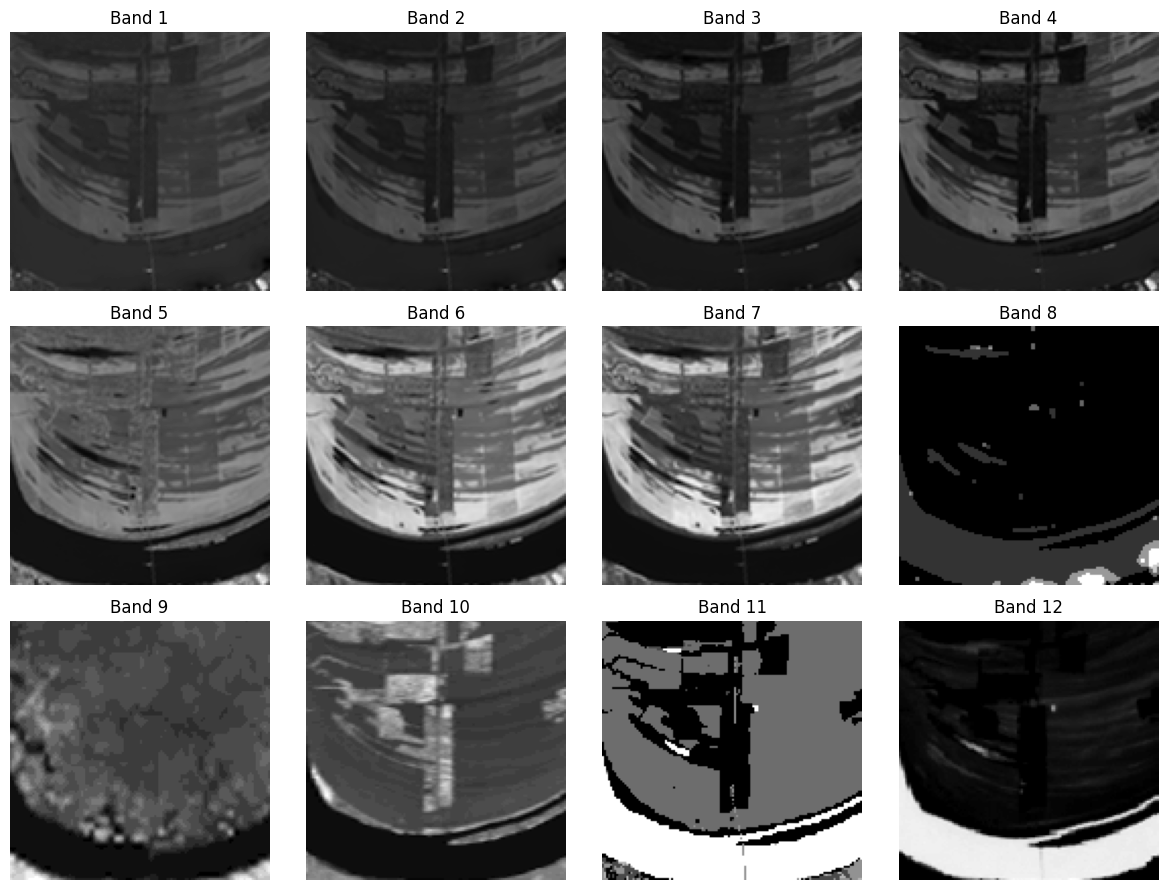

In [4]:
# Visualize the 12 bands of the first training image
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
for i in range(12):
    axs[i//4, i%4].imshow(X_train[0][:,:,i], cmap='gray')
    axs[i//4, i%4].set_title(f'Band {i+1}')
    axs[i//4, i%4].axis('off')
plt.tight_layout()
plt.show()


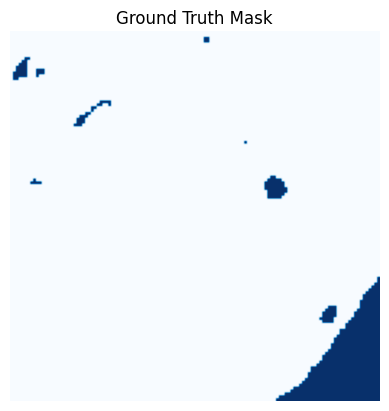

In [5]:
# Visualize the corresponding mask
plt.imshow(y_train[0].squeeze(), cmap='Blues')
plt.title("Ground Truth Mask")
plt.axis('off')
plt.show()


In [9]:
def unet(input_shape=(128, 128, 12)):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)
    
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)
    
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)
    
    # Bottleneck
    b = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p3)
    b = layers.Conv2D(256, (3,3), activation='relu', padding='same')(b)
    
    # Decoder
    u1 = layers.UpSampling2D()(b)
    u1 = layers.Concatenate()([u1, c3])
    c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(u1)
    
    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(u2)
    
    u3 = layers.UpSampling2D()(c5)
    u3 = layers.Concatenate()([u3, c1])
    c6 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u3)
    
    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c6)
    
    model = models.Model(inputs, outputs)
    return model

# Initialize and compile model
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                2)]                                                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 128, 128, 64  6976        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_25 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_24[0][0]']              
                                )                                                             

In [10]:
u_model = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=27
)


Epoch 1/50
10/10 [==============================] - 171s 17s/step - loss: 2.3849 - accuracy: 0.5932 - val_loss: 0.6824 - val_accuracy: 0.6278
Epoch 2/50
10/10 [==============================] - 148s 15s/step - loss: 0.6276 - accuracy: 0.7013 - val_loss: 0.6859 - val_accuracy: 0.6146
Epoch 3/50
10/10 [==============================] - 154s 15s/step - loss: 0.6189 - accuracy: 0.6949 - val_loss: 0.6866 - val_accuracy: 0.6054
Epoch 4/50
10/10 [==============================] - 147s 15s/step - loss: 0.6800 - accuracy: 0.6410 - val_loss: 0.6676 - val_accuracy: 0.6278
Epoch 5/50
10/10 [==============================] - 149s 15s/step - loss: 0.6439 - accuracy: 0.7013 - val_loss: 0.7425 - val_accuracy: 0.6278
Epoch 6/50
10/10 [==============================] - 150s 15s/step - loss: 0.6303 - accuracy: 0.7013 - val_loss: 0.6610 - val_accuracy: 0.6278
Epoch 7/50
10/10 [==============================] - 152s 15s/step - loss: 0.6287 - accuracy: 0.7013 - val_loss: 0.6746 - val_accuracy: 0.6278
Epoch 

In [11]:
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

# Predict on validation set
y_pred = model.predict(X_val)
y_pred_bin = (y_pred > 0.5).astype(int)

# Flatten for metric calculations
y_true_flat = y_val.flatten()
y_pred_flat = y_pred_bin.flatten()

print("IoU (Jaccard):", jaccard_score(y_true_flat, y_pred_flat))
print("Precision     :", precision_score(y_true_flat, y_pred_flat))
print("Recall        :", recall_score(y_true_flat, y_pred_flat))
print("F1 Score      :", f1_score(y_true_flat, y_pred_flat))



2/2 [==============================] - 9s 4s/step
IoU (Jaccard): 0.0


c:\Users\Amr Ibrahim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision     : 0.0
Recall        : 0.0
F1 Score      : 0.0


In [ ]:
model.save("water_segmentation_model.h5")


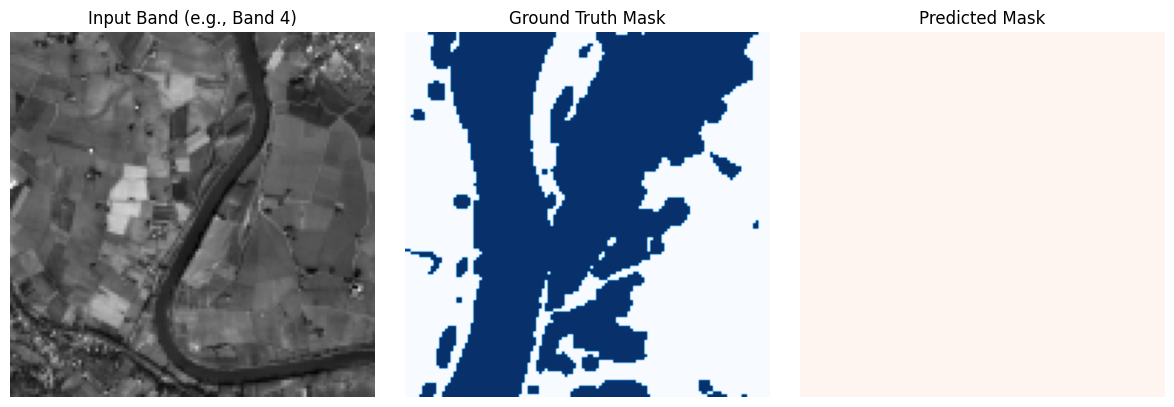

In [ ]:
# Visualize prediction vs ground truth for a sample
index = 0  # change index to visualize other samples

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(X_val[index][:, :, 3], cmap='gray')  # Band 4 example
plt.title("Input Band (e.g., Band 4)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(y_val[index].squeeze(), cmap='Blues')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y_pred_bin[index].squeeze(), cmap='Reds')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()
